# Compare results with TrajGWAS.jl

+ `TrajGWAS.jl` software: https://github.com/OpenMendel/TrajGWAS.jl


In [1]:
using Revise
using QuasiCopula
using TrajGWAS
using CSV
using Glob
using PrettyTables
using GLM
using LinearAlgebra
using SnpArrays
using Suppressor

using Plots
using MendelPlots
gr(fmt=:png)

ENV["COLUMNS"] = 240
BLAS.set_num_threads(1)
Threads.nthreads()

8

## Test data

In [2]:
datadir = normpath(joinpath(dirname(pathof(TrajGWAS)), "../data/"))
readdir(glob"*.*", datadir)

14-element Vector{String}:
 "/Users/biona001/.julia/packages/TrajGWAS/R4aGq/data/bgen_snpsetfile.txt"
 "/Users/biona001/.julia/packages/TrajGWAS/R4aGq/data/covariate.txt"
 "/Users/biona001/.julia/packages/TrajGWAS/R4aGq/data/example.8bits.bgen"
 "/Users/biona001/.julia/packages/TrajGWAS/R4aGq/data/example.8bits.bgen.bgi"
 "/Users/biona001/.julia/packages/TrajGWAS/R4aGq/data/hapmap3.bed"
 "/Users/biona001/.julia/packages/TrajGWAS/R4aGq/data/hapmap3.bim"
 "/Users/biona001/.julia/packages/TrajGWAS/R4aGq/data/hapmap3.fam"
 "/Users/biona001/.julia/packages/TrajGWAS/R4aGq/data/hapmap_snpsetfile.txt"
 "/Users/biona001/.julia/packages/TrajGWAS/R4aGq/data/sim_data.jl"
 "/Users/biona001/.julia/packages/TrajGWAS/R4aGq/data/snpsetfile_vcf.txt"
 "/Users/biona001/.julia/packages/TrajGWAS/R4aGq/data/test_vcf.vcf.gz"
 "/Users/biona001/.julia/packages/TrajGWAS/R4aGq/data/trajgwas_bgen_ex.csv"
 "/Users/biona001/.julia/packages/TrajGWAS/R4aGq/data/trajgwas_plinkex.csv"
 "/Users/biona001/.julia/packages/T

## Run TrajGWAS.jl and QuasiCopula.jl

In [4]:
cov_file = joinpath(datadir * "trajgwas_plinkex.csv")
gen_file = joinpath(datadir * "hapmap3") # PLINK file without .bed/bim/fam extensions
c = joinpath(pwd(), "trajgwas.pval.txt")
nullpath = joinpath(pwd(), "trajgwas.null.txt")
pvalpath = "trajgwas.pval.txt"
group_by = :id # rows with the same `group_by` are considered repeated meatures from sample subject

# trajGWAS
@time trajgwas(
    @formula(y ~ 1 + sex + onMeds + snp1 + snp2 + snp3 + snp4), # formula for mean effects
    @formula(y ~ 1),                # formula for random effects
    @formula(y ~ 1 + sex + onMeds), # formula for within-subject variance
    group_by,
    cov_file,
    gen_file,
    pvalfile = pvalpath, # output file for the gwas p-values
    nullfile = nullpath, # output file for the fitted null model
    usespa = false,       # use saddle point approximation or score test
    verbose = false
);

# QuasiCopula GWAS
df = CSV.read(cov_file, DataFrame)
y = :y
d = Normal()
link = IdentityLink()
covariates = [:sex, :onMeds, :snp1, :snp2, :snp3, :snp4]
qc_model = VC_model(df, y, group_by, covariates, d, link)
@suppress QuasiCopula.fit!(qc_model)
G = SnpData(gen_file)
@time qc_pvals = QuasiCopula.GWASCopulaVCModel(qc_model, G.snparray, check_grad=true);
@time qc_pvals_true = QuasiCopula.GWASCopulaVCModel_autodiff_fast(qc_model, G.snparray, check_grad=true);

# compare p-values
trajGWAS_result = CSV.read(pvalpath, DataFrame)
[qc_pvals qc_pvals_true trajGWAS_result[!, "betapval"]]

run = 1, ‖Δβ‖ = 0.039033, ‖Δτ‖ = 0.320815, ‖ΔL‖ = 0.002056, status = LOCALLY_SOLVED, time(s) = 0.018192
run = 2, ‖Δβ‖ = 0.005078, ‖Δτ‖ = 0.047483, ‖ΔL‖ = 0.004220, status = LOCALLY_SOLVED, time(s) = 0.017036
  0.251722 seconds (1.36 M allocations: 127.855 MiB, 5.47% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Wtime = 0.5896397945000003
Qtime = 0.34983563175000054
Rtime = 0.20008916687500045
grad_res_time = 0.056960249750000004
othertime = 0.029641872
scoretest_time = 0.0012369981249999926
  1.341982 seconds (27.63 M allocations: 1.492 GiB, 9.35% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:16


grad time = 2.3269531629999887
hess time = 14.268320272000038
 18.922988 seconds (19.27 M allocations: 2.348 GiB, 1.02% gc time, 17.59% compilation time: 28% of which was recompilation)


13928×2 Matrix{Float64}:
 NaN            1.0
   0.424284     0.689825
   0.00927372   0.915347
   2.77779e-5   0.539575
   1.0          1.0
 NaN            1.0
   0.735174     0.145089
   0.814919     0.2367
   0.000506267  0.147444
   0.865506     0.914766
 NaN            1.0
   0.537028     0.647976
   0.00934688   0.143678
   ⋮            
   0.0481335    0.996963
   0.0669237    0.976543
   0.0909139    0.912266
   0.0792977    0.979217
   0.106266     0.92517
   0.0066622    0.596064
   0.0934118    0.959083
   0.0986684    0.914567
   0.0937214    0.93992
   0.634259     0.318731
   0.700961     0.911726
   0.227438     0.719769

In [5]:
[qc_pvals qc_pvals_true trajGWAS_result[!, "betapval"]]

13928×3 Matrix{Float64}:
 NaN            NaN            1.0
   0.424284       0.419156     0.689825
   0.00927372     0.00215945   0.915347
   2.77779e-5     5.88632e-8   0.539575
   1.0            1.40301e-14  1.0
 NaN            NaN            1.0
   0.735174       0.729412     0.145089
   0.814919       0.814898     0.2367
   0.000506267    5.62857e-7   0.147444
   0.865506       0.865469     0.914766
 NaN            NaN            1.0
   0.537028       0.536554     0.647976
   0.00934688     0.00238035   0.143678
   ⋮                           
   0.0481335      0.0467218    0.996963
   0.0669237      0.065946     0.976543
   0.0909139      0.0902895    0.912266
   0.0792977      0.0782109    0.979217
   0.106266       0.105738     0.92517
   0.0066622      0.00449954   0.596064
   0.0934118      0.0924861    0.959083
   0.0986684      0.0982547    0.914567
   0.0937214      0.0928458    0.93992
   0.634259       0.628908     0.318731
   0.700961       0.698285     0.911726
   0.22

## QQ plots

all(qc_fail_idx == traj_fail_idx) = false


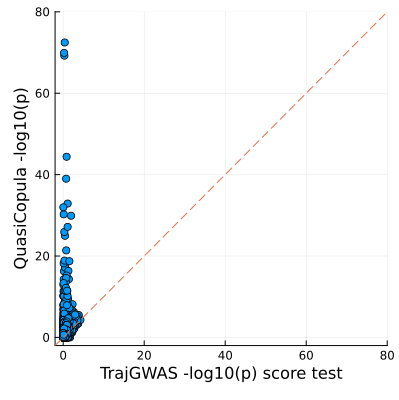

In [105]:
# check QuasiCopula and TrajGWAS fail on same set of SNPs
qc_fail_idx = findall(isnan, qc_pvals)
traj_fail_idx = findall(isone, trajGWAS_result[!, "betapval"])
@show all(qc_fail_idx == traj_fail_idx)

# compare -log10(p-values)
success_idx = findall(!isnan, qc_pvals)
scatter(
    -log10.(trajGWAS_result[success_idx, "betapval"]),
    -log10.(qc_pvals[success_idx]), 
    xlabel = "TrajGWAS -log10(p) score test",
    ylabel = "QuasiCopula -log10(p)",
    label=false,
    size=(400, 400),
    xlim=(-2, 80),
    ylim=(-2, 80),
)
Plots.abline!(1, 0, line=:dash, label=false)

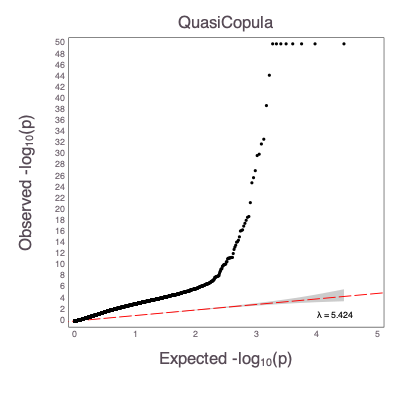

In [6]:
using MendelPlots
idx = findall(!isnan, qc_pvals)
success_pvals = qc_pvals[idx]
idx2 = findall(x -> x < 1e-50, success_pvals)
success_pvals[idx2] .= 1e-50
qq(success_pvals, dpi=80, titles="QuasiCopula")
display("image/png", read("qqplot.png"))

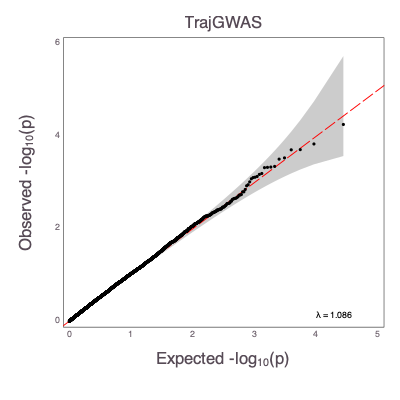

In [106]:
using MendelPlots
idx = findall(!isone, trajGWAS_result[!, "betapval"])
qq(trajGWAS_result[idx, "betapval"], dpi=80, titles="TrajGWAS")
display("image/png", read("qqplot.png"))